Based off of
https://colab.research.google.com/drive/1njyOjtWLvh1zB6yvftcntD-qhwszTOW3.

### Load libraries

In [2]:
import dataclasses
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

### Helper functions

In [3]:
@dataclasses.dataclass
class Dataset:
    xs: np.ndarray
    ys: np.ndarray

    def __post_init__(self):
        assert self.xs.shape[0] == self.ys.shape[0]
        assert self.xs.ndim == 2
        assert self.ys.ndim == 1


@dataclasses.dataclass
class DataParams:
    w_true: np.ndarray
    sigma: float

    def __post_init__(self):
        assert self.w_true.ndim == 1
        assert self.sigma >= 0

    @property
    def d(self) -> int:
        return self.w_true.shape[0]

    def gen_data(self, n: int) -> Dataset:
        """y = w_true @ x + N(0, sigma^2)"""
        (d,) = self.w_true.shape
        xs = np.random.normal(size=(n, d))
        ys = xs @ self.w_true + np.random.normal(size=(n,), scale=self.sigma)
        return Dataset(xs=xs, ys=ys)

    def get_opt_lam(self) -> float:
        """
        Returns the optimal lambda for ridge regression.
        See https://arxiv.org/pdf/2003.01897.pdf#lemma.2.
        """
        return self.d * (self.sigma**2) / (np.linalg.norm(self.w_true) ** 2)  # type: ignore


def est_w(
    ds: Dataset,
    lam: float,
) -> np.ndarray:
    """
    Returns argmin_w ||y - Xw||^2 + lam ||w||^2

    Adapted from https://arxiv.org/pdf/2003.01897.pdf.
    """
    (n, d) = ds.xs.shape
    assert ds.ys.shape == (n,)
    assert lam >= 0

    X, y = ds.xs, ds.ys

    # Compute the matrix A = X^T X + lam I
    A = X.T @ X + lam * np.eye(d)

    # Compute the vector b = X^T y
    b = X.T @ y

    # Solve the linear system A w = b
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w

### Generate data

In [4]:
# Reproducing plot in https://arxiv.org/pdf/2003.01897.pdf#figure.caption.1

SEED = 0
DIMS = 500
N_TRIALS = 50
dp = DataParams(
    w_true=np.array([1] + [0 for _ in range(DIMS - 1)], dtype=np.float32),
    sigma=0.5,
)


def gen_n_trains(max: int):
    base = 1
    while True:
        for i in range(1, 10):
            ret = base * i
            if ret >= max:
                yield max
                return
            else:
                yield ret
        base *= 10


np.random.seed(SEED)
results: list[dict[str, Any]] = []
n_trains = list(gen_n_trains(max=100 * DIMS))
for n in tqdm(n_trains):
    for i in range(N_TRIALS):
        ds = dp.gen_data(n=n)
        lam = dp.get_opt_lam()

        w_map = est_w(ds=ds, lam=lam)
        w_mle = est_w(ds=ds, lam=0)

        results.append(
            dict(
                map_mse=np.linalg.norm(w_map - dp.w_true) ** 2,  # type: ignore
                mle_mse=np.linalg.norm(w_mle - dp.w_true) ** 2,  # type: ignore
                n_train=n,
                trial=i,
            )
        )

df = pd.DataFrame(results)

  0%|          | 0/41 [00:00<?, ?it/s]

### Make plots

In [12]:
def fancy_plot(
    df: pd.DataFrame,
    target: str = "err",
    ci: float = 0.99,
    gb_target: str = "n_train",
    err_irreducible: float = 0.0,
    **kwargs,
):
    gb = df.groupby(gb_target)

    ax = (gb[target].median() + err_irreducible).plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2) + err_irreducible, 
        gb[target].quantile(0.5 + ci / 2) + err_irreducible,
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    return dict(ax=ax, gb=gb)

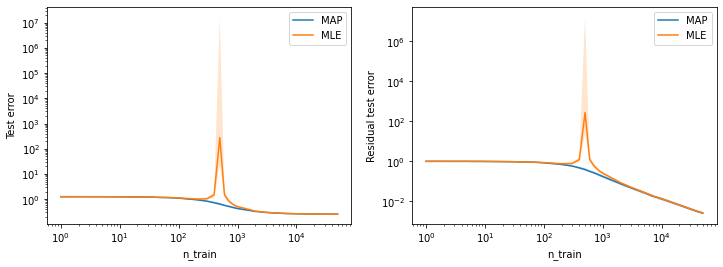

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
fancy_plot(df=df, target="map_mse", label="MAP", err_irreducible=dp.sigma ** 2)
fancy_plot(df=df, target="mle_mse", label="MLE", err_irreducible=dp.sigma ** 2)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Test error")
plt.legend()

plt.subplot(1, 2, 2)
fancy_plot(df=df, target="map_mse", label="MAP")
fancy_plot(df=df, target="mle_mse", label="MLE")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Residual test error")
plt.legend()

plt.show()